In [134]:
# Munging imports

import pandas as pd
import numpy as np

# Visualiztion imports
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import shap
shap.initjs()

# Modeling imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, auc, confusion_matrix
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, roc_curve, classification_report
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, tree, naive_bayes
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
# Import csv from previous notebook as a data frame

PERM_VISA = pd.read_csv("applications_3.csv", index_col = 0)
PERM_VISA.rename(columns=lambda x: x.strip(), inplace=True)
PERM_VISA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91704 entries, 0 to 91703
Data columns (total 21 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Permanent Certification Approved                        91704 non-null  int64  
 1   No of employees for company                             91704 non-null  float64
 2   Skill level (1-4)                                       91704 non-null  int64  
 3   Specific skills listed                                  91704 non-null  int64  
 4   Decision made during Trump administration               91704 non-null  int64  
 5   Decision made during Biden administration               91704 non-null  int64  
 6   Days between application and decision                   91704 non-null  int64  
 7   Salary offer                                            91704 non-null  int64  
 8   FAANG or other prominent employer   

In [3]:
# When checking for the breakdown by approved by declined applications, we see a severe imbalance
# Only 7.07% of all applications in consideration were declined
# We will handle this during modeling by using the "balanced" class weight 

PERM_VISA.groupby("Permanent Certification Approved").count()

,No of employees for company,Skill level (1-4),Specific skills listed,Decision made during Trump administration,Decision made during Biden administration,Days between application and decision,Salary offer,FAANG or other prominent employer,Majored in Comp Sci or Engineering,Majored in Medicine,Majored in Accounting,Majored in Business Administration,Received education in the U.S.,Possesses Bachelor's Degree,Possesses Master's Degree,Possesses Doctorate Degree,H1B Visa Holder,TN Visa Holder,Literacy rate of country of origin,Education expenditure as % of GDP of country of origin
Permanent Certification Approved,,,,,,,,,,,,,,,,,,,,
0,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488
1,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216


In [4]:
# Flip the target around and try to predict what could contribute to an application getting declined and 
# minimize the probability of this occurring

PERM_VISA.rename(columns = {"Permanent Certification Approved": "Application Declined"}, inplace = True)
PERM_VISA["Application Declined"] = np.where(PERM_VISA["Application Declined"] == 1, 0, 1)

In [5]:
PERM_VISA.groupby("Application Declined").count()

,No of employees for company,Skill level (1-4),Specific skills listed,Decision made during Trump administration,Decision made during Biden administration,Days between application and decision,Salary offer,FAANG or other prominent employer,Majored in Comp Sci or Engineering,Majored in Medicine,Majored in Accounting,Majored in Business Administration,Received education in the U.S.,Possesses Bachelor's Degree,Possesses Master's Degree,Possesses Doctorate Degree,H1B Visa Holder,TN Visa Holder,Literacy rate of country of origin,Education expenditure as % of GDP of country of origin
Application Declined,,,,,,,,,,,,,,,,,,,,
0,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216,85216
1,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488,6488


/Users/oppur/Desktop/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/oppur/Desktop/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/oppur/Desktop/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/oppur/Desktop/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/oppur/Desktop/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/oppur/Desktop/anaconda3/lib/python3.8/site-packages/seabor

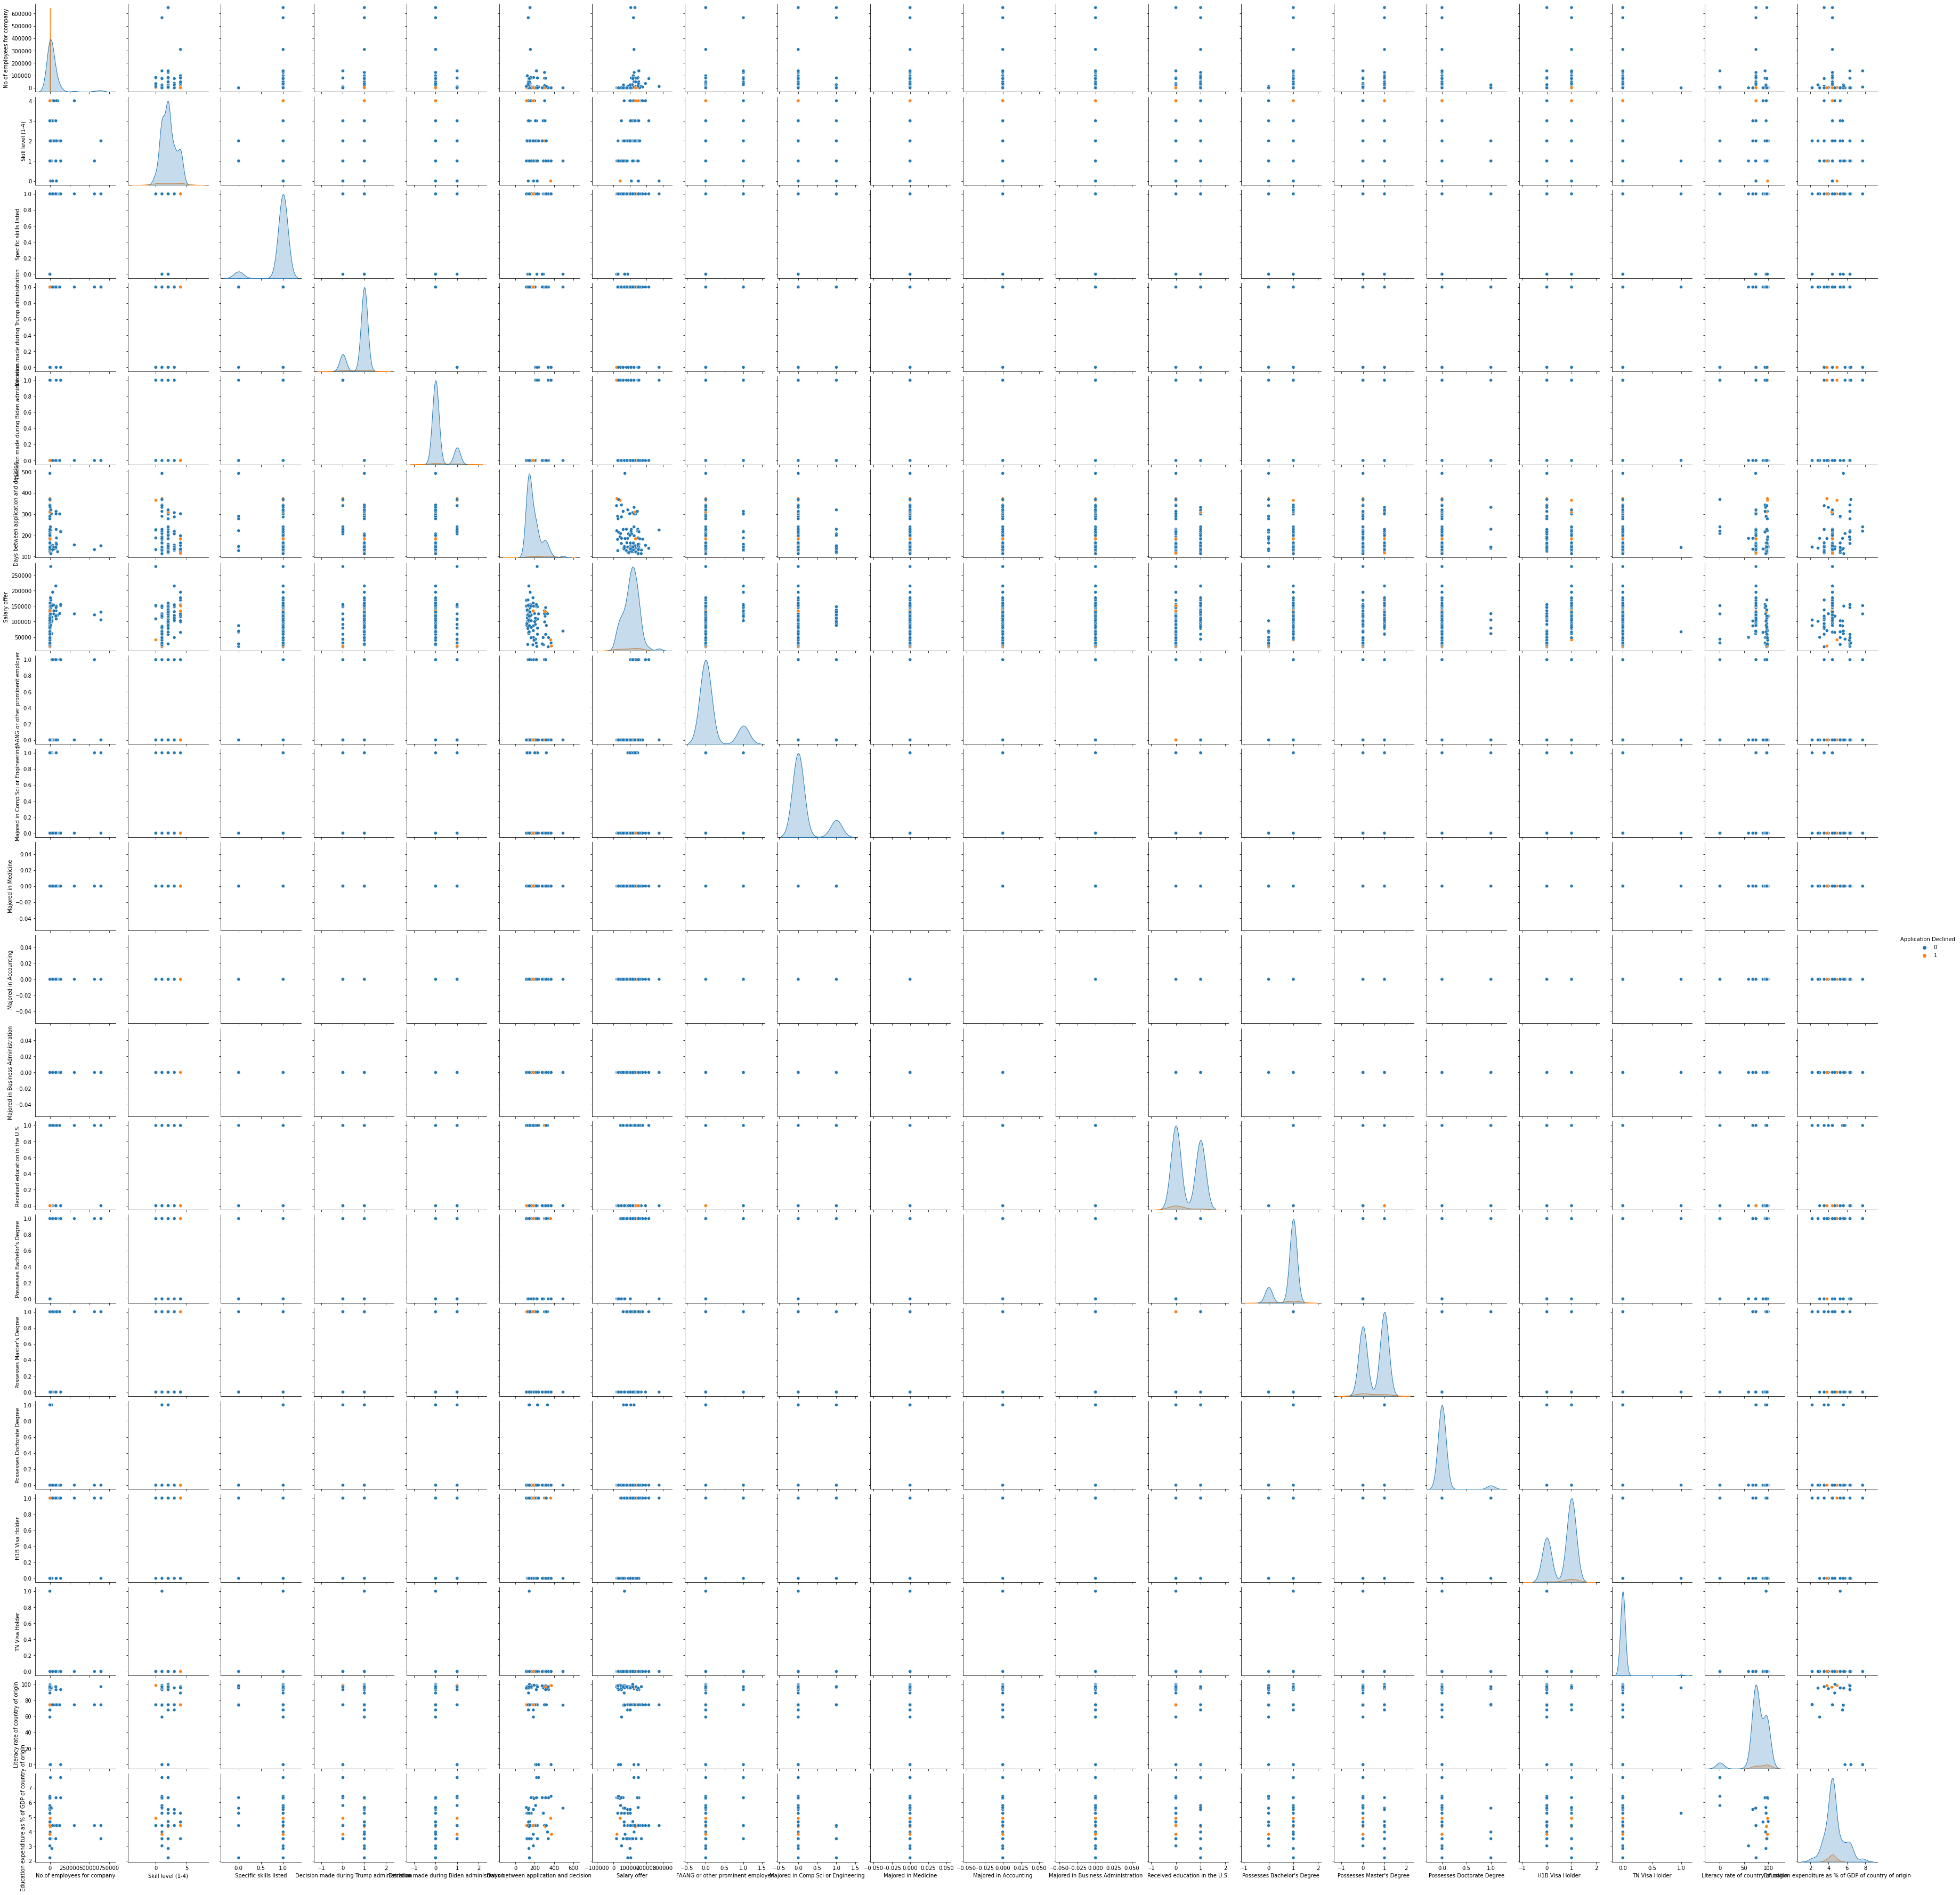

In [6]:
# Check pairplot to see if we can determine the most predictive features

X, y = PERM_VISA.drop(["Application Declined"], axis=1), PERM_VISA["Application Declined"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
train_df = X_train.copy()
train_df["Application Declined"] = y_train
sns.pairplot(train_df.sample(100), hue = "Application Declined", diag_kind = 'kde');

In [7]:
PERM_VISA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91704 entries, 0 to 91703
Data columns (total 21 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Application Declined                                    91704 non-null  int64  
 1   No of employees for company                             91704 non-null  float64
 2   Skill level (1-4)                                       91704 non-null  int64  
 3   Specific skills listed                                  91704 non-null  int64  
 4   Decision made during Trump administration               91704 non-null  int64  
 5   Decision made during Biden administration               91704 non-null  int64  
 6   Days between application and decision                   91704 non-null  int64  
 7   Salary offer                                            91704 non-null  int64  
 8   FAANG or other prominent employer   

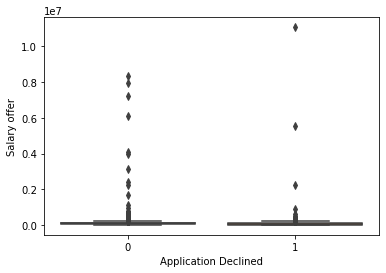

In [8]:
# There are too many features to easily visualize in a pair plot...
# Instead, let's try box plots individually on the continuous feature variables

sns.boxplot(x = "Application Declined", y = "Salary offer", data = train_df);

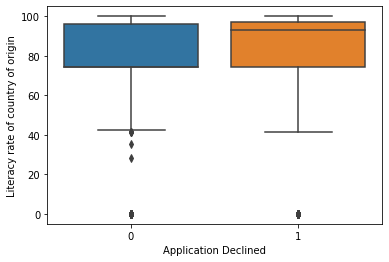

In [9]:
sns.boxplot(x = "Application Declined", y = "Literacy rate of country of origin", data = train_df);

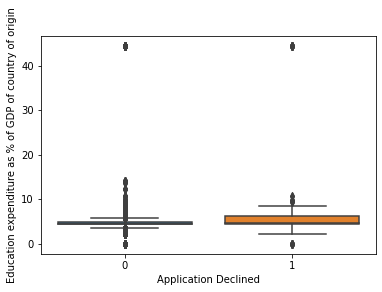

In [10]:
sns.boxplot(x = "Application Declined", y = "Education expenditure as % of GDP of country of origin", data = train_df);

##### Above box plots showed no discernible findings. 

### Logistic Regression

In [11]:
X_mid, X_test, y_mid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_mid, y_mid, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

In [19]:
def gen_confusion_matrix(model, threshold = 0.6):
    y_predict = (model.predict_proba(X_test_sc)[:,1] >= threshold)
    success_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(success_confusion, cmap=plt.cm.Blues, annot = True, square = True, fmt= "d",
           xticklabels=["Approved", "Declined"],
           yticklabels=["Approved", "Declined"]);
    plt.xlabel("Predicted Application Outcome")
    plt.ylabel("Actual Application Outcome")

In [16]:
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear') 
lr_balanced.fit(X_train_sc, y_train)
lr_balanced_pred = lr_balanced.predict(X_test_sc)
lr_balanced_confusion = confusion_matrix(y_test, lr_balanced_pred)

lr_balanced_ac = lr_balanced.score(X_test_sc, y_test)
lr_balanced_precision = precision_score(y_test, lr_balanced_pred)
lr_balanced_recall = recall_score(y_test, lr_balanced_pred)
lr_balanced_f1 = f1_score(y_test, lr_balanced_pred)

lr_balanced_y_score = lr_balanced.predict_proba(X_test_sc)[:,1]
lr_balanced_fpr, lr_balanced_tpr, lr_balanced_auc_thresholds = roc_curve(y_test, lr_balanced_y_score)
roc_auc_lr_balanced = auc(lr_balanced_fpr, lr_balanced_tpr)

print(classification_report(y_test, lr_balanced_pred))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     17042
           1       0.26      0.79      0.39      1299

    accuracy                           0.83     18341
   macro avg       0.62      0.81      0.64     18341
weighted avg       0.93      0.83      0.86     18341



##### Note that we wish to minimize false negatives (declined applications being classified as approved). Hence, recall is emphasized over precision.

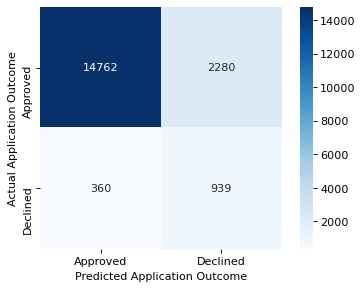

In [20]:
gen_confusion_matrix(lr_balanced)

In [141]:
print('Logistic Regression validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (lr_balanced_ac, 
         lr_balanced_precision, 
         lr_balanced_recall,
         lr_balanced_f1)
     )

Logistic Regression validation metrics: 
 Accuracy: 0.8260 
 Precision: 0.2598 
 Recall: 0.7883 
 F1: 0.3908


In [142]:
print(roc_auc_lr_balanced)

0.8672739784577865


### K-Nearest Neighbors

In [21]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_sc, y_train)
knn_pred = knn.predict(X_val_sc)
knn_confusion = confusion_matrix(y_val,knn_pred)

knn_ac = knn.score(X_val_sc, y_val)
knn_precision = precision_score(y_val, knn_pred)
knn_recall = recall_score(y_val, knn_pred)
knn_f1 = f1_score(y_val, knn_pred)

print(classification_report(y_val, knn_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     13631
           1       0.75      0.40      0.52      1042

    accuracy                           0.95     14673
   macro avg       0.86      0.70      0.75     14673
weighted avg       0.94      0.95      0.94     14673



In [22]:
# Check KNN model with increased neighbor value for testing

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train_sc, y_train)
knn_pred = knn.predict(X_val_sc)
knn_confusion = confusion_matrix(y_val,knn_pred)

knn_ac = knn.score(X_val_sc, y_val)
knn_precision = precision_score(y_val, knn_pred)
knn_recall = recall_score(y_val, knn_pred)
knn_f1 = f1_score(y_val, knn_pred)

print(classification_report(y_val, knn_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13631
           1       0.83      0.34      0.48      1042

    accuracy                           0.95     14673
   macro avg       0.89      0.67      0.73     14673
weighted avg       0.94      0.95      0.94     14673



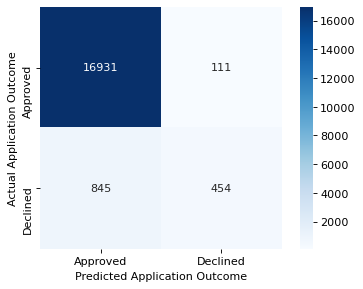

In [23]:
gen_confusion_matrix(knn)

##### Compared to logistic regression's confusion matrix, KNN's matrix has too many false negatives in relation to true positives

In [107]:
knn_y_score = knn.predict_proba(X_val_sc)[:,1]
knn_fpr, knn_tpr, knn_auc_thresholds = roc_curve(y_val, knn_y_score)
roc_auc_knn = auc(knn_fpr, knn_tpr)

### Decision Tree

In [29]:
dt = DecisionTreeClassifier(class_weight = "balanced")
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_val)

dt_ac = dt.score(X_val, y_val)
dt_precision = precision_score(y_val, dt_pred)
dt_recall = recall_score(y_val, dt_pred)
dt_f1 = f1_score(y_val, dt_pred)

print(classification_report(y_val, dt_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     13631
           1       0.61      0.59      0.60      1042

    accuracy                           0.94     14673
   macro avg       0.79      0.78      0.79     14673
weighted avg       0.94      0.94      0.94     14673



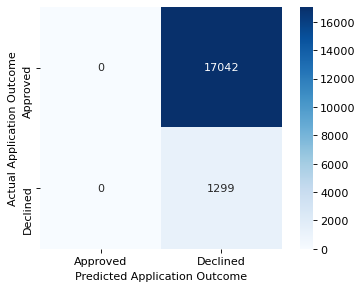

In [26]:
gen_confusion_matrix(dt)

##### The model predicted every application as failing... Let's try again after raising threshold for positive prediction

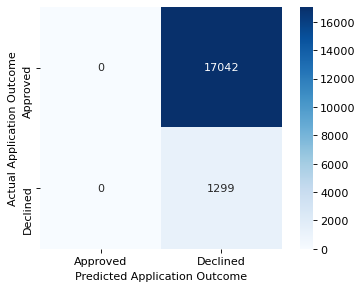

In [71]:
gen_confusion_matrix(dt, threshold = 0.95)

In [108]:
dt_y_score = dt.predict_proba(X_val)[:, 1]
dt_fpr, dt_tpr, auc_thresholds = roc_curve(y_val, dt_y_score)
roc_auc_dt = auc(dt_fpr, dt_tpr)

### Random Forest

In [30]:
rf = RandomForestClassifier(class_weight = "balanced")
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
rf_confusion = confusion_matrix(y_val, rf_pred)

rf_ac = rf.score(X_val, y_val)
rf_precision = precision_score(y_val, rf_pred)
rf_recall = recall_score(y_val, rf_pred)
rf_f1 = f1_score(y_val, rf_pred)

print(classification_report(y_val, rf_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13631
           1       0.91      0.52      0.66      1042

    accuracy                           0.96     14673
   macro avg       0.94      0.76      0.82     14673
weighted avg       0.96      0.96      0.96     14673



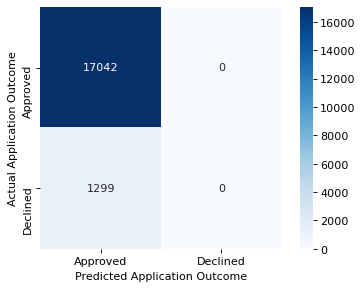

In [31]:
gen_confusion_matrix(rf)

##### Random forest is predicting everything as negative... Let's try lowering the threshold for positive prediction

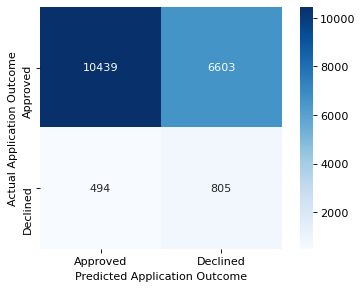

In [69]:
gen_confusion_matrix(rf, threshold = 0.45)

In [109]:
rf_y_score = rf.predict_proba(X_val)[:, 1]
rf_fpr, rf_tpr, auc_thresholds = roc_curve(y_val, rf_y_score)
roc_auc_rf = auc(rf_fpr, rf_tpr)

### XGBoost

In [139]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_val)

xg_ac = xg.score(X_val, y_val)
xg_precision = precision_score(y_val, xg_pred)
xg_recall = recall_score(y_val, xg_pred)
xg_f1 = f1_score(y_val, xg_pred)

xg_y_score = xg.predict_proba(X_val)[:, 1]
xg_fpr, xg_tpr, auc_thresholds = roc_curve(y_val, xg_y_score)
roc_auc_xg = auc(xg_fpr, xg_tpr)

print(classification_report(y_val, xg_pred))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:27:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     13631
           1       0.96      0.63      0.76      1042

    accuracy                           0.97     14673
   macro avg       0.97      0.82      0.87     14673
weighted avg       0.97      0.97      0.97     14673



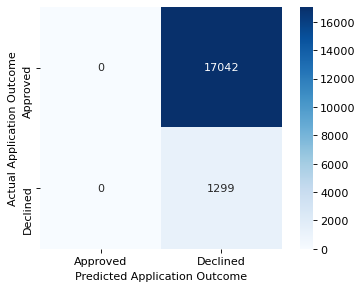

In [82]:
gen_confusion_matrix(xg, threshold = 0.6)

##### Tinker with threshold once more to see if any negative predictions can be made

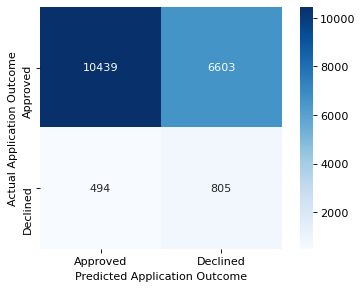

In [85]:
gen_confusion_matrix(rf, threshold = 0.45)

In [110]:
xg_y_score = xg.predict_proba(X_val)[:, 1]
xg_fpr, xg_tpr, auc_thresholds = roc_curve(y_val, xg_y_score)
roc_auc_xg = auc(xg_fpr, xg_tpr)

### Gaussian Naive Bayes

In [88]:
gnb = naive_bayes.GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_val)
gnb_confusion = confusion_matrix(y_val, gnb_pred)

gnb_ac = gnb.score(X_val, y_val)
gnb_precision = precision_score(y_val, gnb_pred)
gnb_recall = recall_score(y_val, gnb_pred)
gnb_f1 = f1_score(y_val, gnb_pred)

print(classification_report(y_val, gnb_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     13631
           1       0.55      0.16      0.24      1042

    accuracy                           0.93     14673
   macro avg       0.74      0.57      0.60     14673
weighted avg       0.91      0.93      0.91     14673



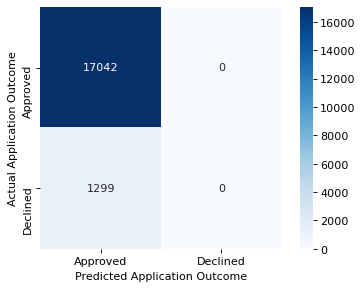

In [92]:
gen_confusion_matrix(gnb, threshold = 0.6)

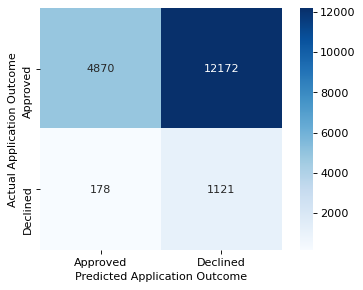

In [97]:
gen_confusion_matrix(gnb, threshold = 0.26)

In [111]:
gnb_y_score = gnb.predict_proba(X_val)[:, 1]
gnb_fpr, gnb_tpr, auc_thresholds = roc_curve(y_val, gnb_y_score)
roc_auc_gnb = auc(gnb_fpr, gnb_tpr)

### Bernoulli Naive Bayes

In [98]:
bnb = naive_bayes.BernoulliNB()
bnb.fit(X_train, y_train)
bnb_pred = bnb.predict(X_val)
bnb_confusion = confusion_matrix(y_val, gnb_pred)

bnb_ac = gnb.score(X_val, y_val)
bnb_precision = precision_score(y_val, bnb_pred)
bnb_recall = recall_score(y_val, bnb_pred)
bnb_f1 = f1_score(y_val, bnb_pred)

print(classification_report(y_val, bnb_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92     13631
           1       0.22      0.45      0.30      1042

    accuracy                           0.85     14673
   macro avg       0.59      0.66      0.61     14673
weighted avg       0.90      0.85      0.87     14673



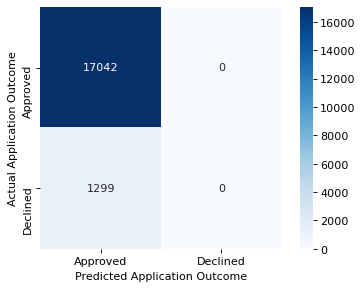

In [99]:
gen_confusion_matrix(gnb, threshold = 0.6)

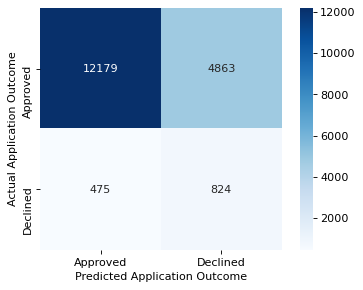

In [105]:
gen_confusion_matrix(gnb, threshold = 0.27)

In [112]:
bnb_y_score = bnb.predict_proba(X_val)[:, 1]
bnb_fpr, bnb_tpr, auc_thresholds = roc_curve(y_val, bnb_y_score)
roc_auc_bnb = auc(bnb_fpr, bnb_tpr)

### Model Comparison Using ROC/AUC

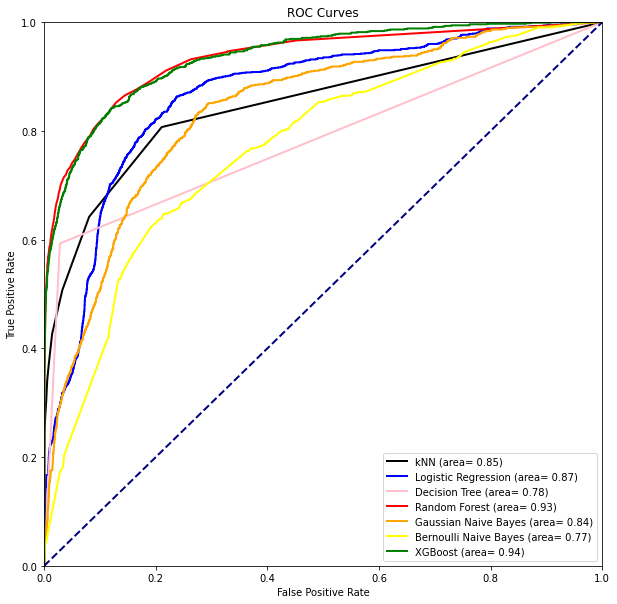

In [116]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(knn_fpr, knn_tpr, color='black', lw=lw, 
         label='kNN (area= %0.2f)' %roc_auc_knn)
plt.plot(lr_balanced_fpr, lr_balanced_tpr, color='blue', lw=lw, 
         label='Logistic Regression (area= %0.2f)' %roc_auc_lr_balanced)
plt.plot(dt_fpr, dt_tpr, color='pink', lw=lw, 
         label='Decision Tree (area= %0.2f)' %roc_auc_dt)
plt.plot(rf_fpr, rf_tpr, color='red', lw=lw, 
         label='Random Forest (area= %0.2f)' %roc_auc_rf)
plt.plot(gnb_fpr, gnb_tpr, color='orange', lw=lw, 
         label='Gaussian Naive Bayes (area= %0.2f)' %roc_auc_gnb)
plt.plot(bnb_fpr, bnb_tpr, color='yellow', lw=lw, 
         label='Bernoulli Naive Bayes (area= %0.2f)' %roc_auc_bnb)
plt.plot(xg_fpr, xg_tpr, color='green', lw=lw,
        label='XGBoost (area= %0.2f)' %roc_auc_xg)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right');

##### Looking at above AUC chart, top three performing models are
1) XGBoost (0.94 AUC)
2) Random Forest (0.93 AUC)
3) Logistic Regression (0.87 AUC)

We can begin tuning hyperparameters

In [140]:
print('XGBoost validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC: %.4f' %
        (xg_ac, 
         xg_precision, 
         xg_recall,
         xg_f1,
         roc_auc_xg)
     )

XGBoost validation metrics: 
 Accuracy: 0.9721 
 Precision: 0.9607 
 Recall: 0.6334 
 F1: 0.7634 
 ROC: 0.9748


In [138]:
PERM_VISA.to_csv("applications_4.csv")